In [23]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *

import math
import numpy as np
import pandas as pd
import numpy.matlib

from scipy.io import loadmat, savemat
from scipy import interpolate
from scipy.stats import norm, multivariate_normal, multivariate_t, t
from scipy.special import expit
from scipy.optimize import minimize

from sklearn.model_selection import train_test_split

import plotly.graph_objects as go
import matplotlib.pyplot as plt
from IPython.display import Image
import seaborn as sns

import time
import os
import yfinance as yf
import importlib

from functools import partial
from statsmodels.graphics.gofplots import qqplot
from statsmodels import distributions
import statsmodels.api as sm
from scipy.stats import gaussian_kde
from matplotlib import cm
from scipy.interpolate import RectBivariateSpline



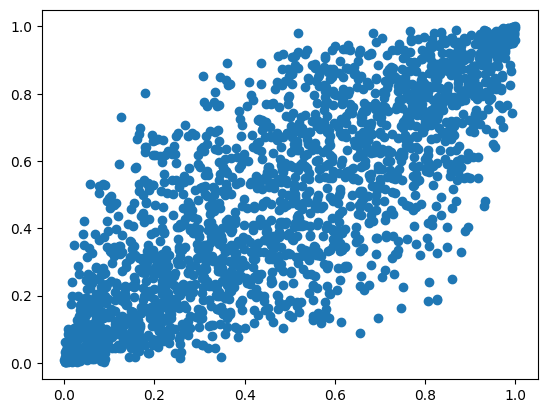

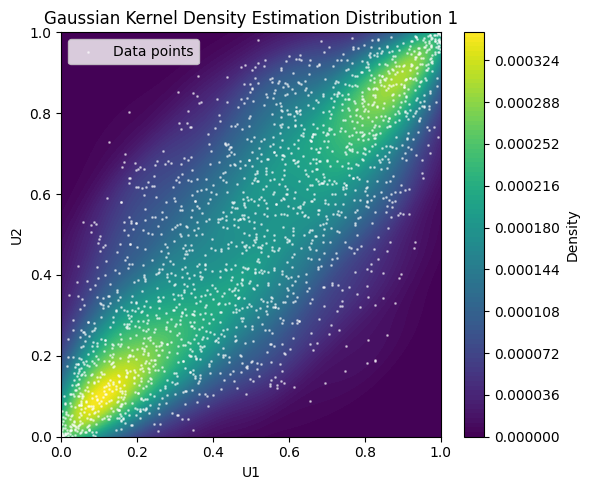

In [43]:
corrMat = np.array([[1, 0.8], [0.8, 1]])
A = np.linalg.cholesky(corrMat)
np.random.seed(0)
Z = np.random.standard_normal((2000, 2))
X = (A @ Z.T).T


U = norm.cdf(X)   
plt.scatter(U[:, 0], U[:, 1])

num_points = 100
dimRange = np.linspace(0, 1, num_points)


## create meshgrid
U1_grid, U2_grid = np.meshgrid(dimRange, dimRange)
grid_coords = np.vstack([U1_grid.ravel(), U2_grid.ravel()]).T

## estimate 2D KDEs
kde_U = gaussian_kde(U.T)

## compute density at each grid point
Z_U = kde_U(grid_coords.T)

# Normalize to form probability distributions (sum to 1)
Z_U /= Z_U.sum()

## Reshape Z for plotting
Z_U = Z_U.reshape(U1_grid.shape)

## Plot the estimated density
plt.figure(figsize=(6,5))
plt.contourf(U1_grid, U2_grid, Z_U, levels=100, cmap='viridis')
plt.colorbar(label='Density')
plt.scatter(U[:, 0], U[:, 1], s=1, color='white', alpha=0.5, label='Data points')
plt.title("Gaussian Kernel Density Estimation Distribution 1")
plt.xlabel("U1")
plt.ylabel("U2")
plt.legend()
plt.tight_layout()
plt.show()

Z_cdf_U = Z_U.cumsum(axis=0).cumsum(axis=1)


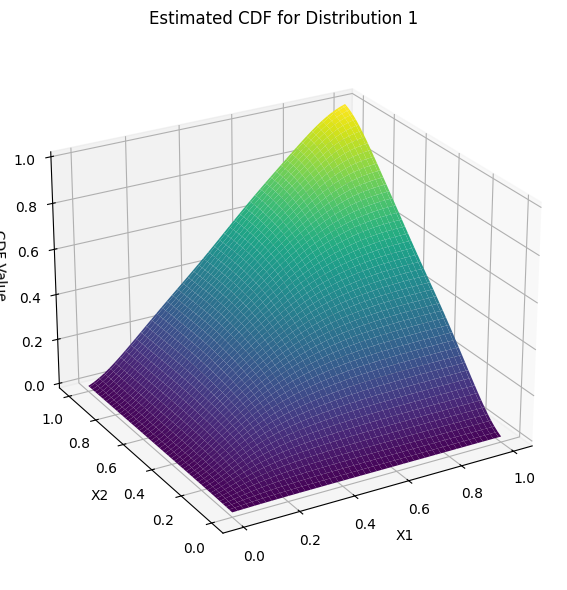

In [44]:
U1_mesh, U2_mesh = np.meshgrid(dimRange,dimRange)

# Plot CDF for X
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(U1_mesh, U2_mesh, Z_cdf_U, cmap=cm.viridis, edgecolor='none')
ax.set_title("Estimated CDF for Distribution 1")
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_zlabel("CDF Value")
#fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.view_init(elev=25, azim=240, roll=0)
plt.tight_layout()
plt.show()

In [53]:

from scipy.interpolate import SmoothBivariateSpline

# Get 1D coordinate vectors
u1 = U1_mesh[0, :]  # or use np.unique(U1_mesh)
u2 = U2_mesh[:, 0]  # or use np.unique(U2_mesh)


n_boundary = 100
u_vals = np.linspace(0, 1, n_boundary)

# ---- Boundary 1: (0, u2), value = 0
u1_b1 = np.zeros(n_boundary)
u2_b1 = u_vals
z_b1 = np.zeros(n_boundary)

# ---- Boundary 2: (1, u2), value = u2
u1_b2 = np.ones(n_boundary)
u2_b2 = u_vals
z_b2 = u_vals

# ---- Boundary 3: (u1, 0), value = 0
u1_b3 = u_vals
u2_b3 = np.zeros(n_boundary)
z_b3 = np.zeros(n_boundary)

# ---- Boundary 4: (u1, 1), value = u1
u1_b4 = u_vals
u2_b4 = np.ones(n_boundary)
z_b4 = u_vals

# ---- Concatenate all boundary data
u1_boundary = np.concatenate([u1_b1, u1_b2, u1_b3, u1_b4])
u2_boundary = np.concatenate([u2_b1, u2_b2, u2_b3, u2_b4])
z_boundary = np.concatenate([z_b1, z_b2, z_b3, z_b4])


z_original_flat = Z_cdf_U.ravel()  # or use .flatten()
z_all = np.concatenate([z_original_flat, z_boundary])

u1_flat = U1_mesh.ravel()
u2_flat = U2_mesh.ravel()
u1_all = np.concatenate([u1_flat, u1_boundary])
u2_all = np.concatenate([u2_flat, u2_boundary])

spline = SmoothBivariateSpline(u1_all, u2_all, z_all, kx=3, ky=3)


# Compute partial derivatives:
dC_du = spline(u, v, dx=1, dy=0)
dC_dv = spline(u, v, dx=0, dy=1)
d2C_dudv = spline(u, v, dx=1, dy=1)


In [54]:
print(f"Min/max u1: {u1_all.min()} to {u1_all.max()}")
print(f"Min/max u2: {u2_all.min()} to {u2_all.max()}")

Min/max u1: 0.0 to 1.0
Min/max u2: 0.0 to 1.0


In [105]:
# Evaluate at any (u, v)


u = 1
v = 1
C_uv = spline(u, v)
C_uv

array([[1.02886597]])

In [ ]:
def SplineCompute(u,v,spline):
    """
    Compute the spline value and its derivatives at (u, v).
    """
    C_uv = spline(u, v)
    if C_uv <0: 
        C_uv = 0
    elif C_uv > 1:
        C_uv = 1
    return C_uv
    




1.0
[[1.02886597]]


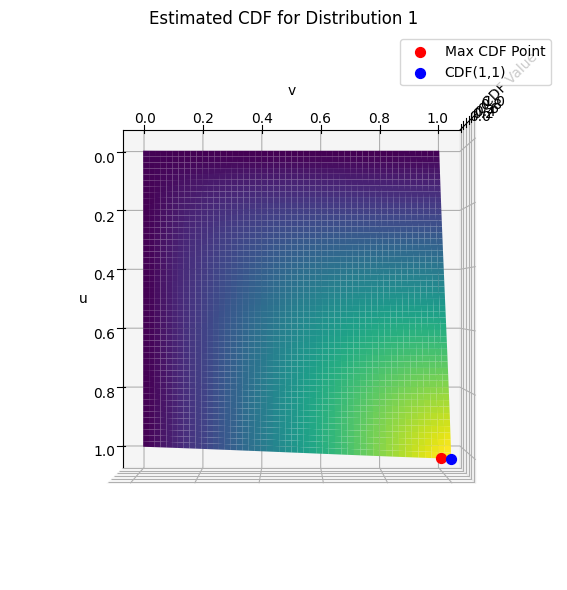

In [ ]:
import numpy as np

# Number of points along each axis
num_points = 1000

# Create a 1D range for u and v
u_vals = np.linspace(0, 1, num_points)
v_vals = np.linspace(0, 1, num_points)
U_grid, V_grid = np.meshgrid(u_vals, v_vals)
C_grid = spline(U_grid, V_grid, grid=False) 


C_grid[C_grid < 0] = 0
C_grid[C_grid > 1] = 1





# print(np.argmax(C_grid))

# print(np.argmin(C_grid))

idx_flat = np.argmax(C_grid)  # Index in flattened array
idx_2d = np.unravel_index(idx_flat, C_grid.shape)  # Convert to (i, j)

# Get the coordinates:
u_at_max = U_grid[idx_2d]
v_at_max = V_grid[idx_2d]
C_max = C_grid[idx_2d]
print(C_max)



fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# Surface plot
surf = ax.plot_surface(U_grid, V_grid, C_grid, cmap=cm.viridis, edgecolor='none')

# Max point
ax.scatter(u_at_max, v_at_max, C_max, color='red', s=50, label='Max CDF Point')
ax.scatter(1,1,spline(1,1), color='blue', s=50, label='CDF(1,1)')

# Labels and view
ax.set_title("Estimated CDF for Distribution 1")
ax.set_xlabel("u")
ax.set_ylabel("v")
ax.set_zlabel("CDF Value")
ax.view_init(elev=90, azim=0, roll=0)

# Optional: colorbar and legend
# fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)
ax.legend()

plt.tight_layout()
plt.show()

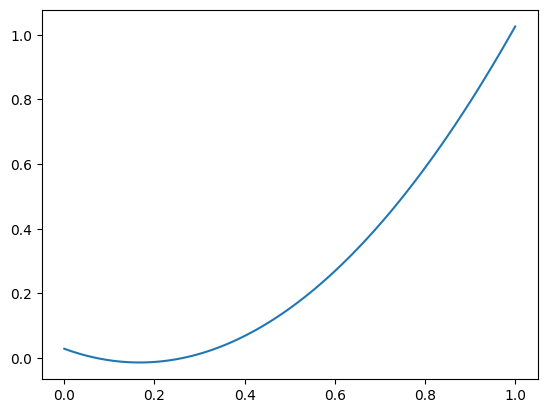

In [117]:
u1 = 0.8
u2 = np.linspace(0, 1, 100)

dC_du = spline(u1, u2, dx=1, dy=0)

plt.plot(u2, dC_du[0,:], label='dC/du at u1=0.5')